#Drawing boundaries 

In [1]:
import fiona
import shapely.geometry as geometry

input_shapefile = 'data/concave_demo_points.shp'
shapefile = fiona.open(input_shapefile)
points = [geometry.shape(point['geometry']) for point in shapefile]
print("We have {0} points!".format(len(points)))

We have 143 points!


## ok, so what did that do?
We just loaded a "shapefile." Shapefiles are one of the most commonly used formats for saving geometries. Developed by ESRI, and open.

We can use pylab now to plot those points.

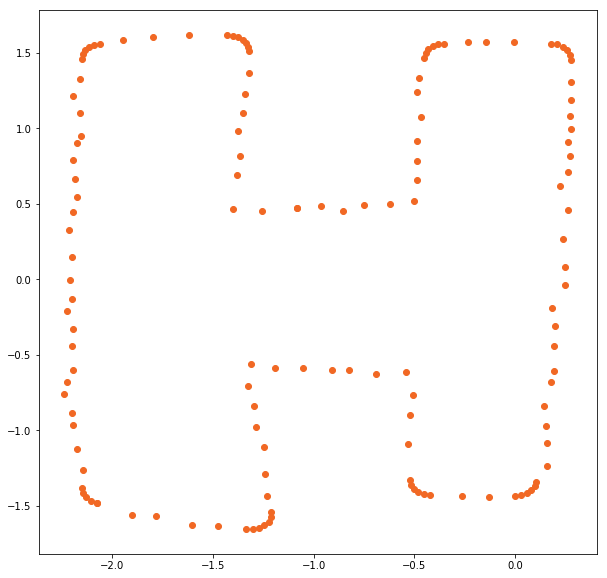

In [3]:
%matplotlib inline 
import pylab as pl

# The following proves that I don't know numpy in the slightest
x = [p.coords.xy[0] for p in points]
y = [p.coords.xy[1] for p in points]

pl.figure(figsize=(10,10))
_ = pl.plot(x,y,'o', color='#f16824')

## points!
But now we have points. I used QGIS to draw these points in the rough shape of a capital "H". I highly recommend that you `brew install qgis-22` (or equivalent) if you want to play with geometric features.

## envelope
Now that you have a collection of points, you can interrogate the collection. Many shapely operations result in a different kind of geometry than the one you're working with. Since our geometry is a collection of points, I can instantiate a MultiPoint, and then ask that MultiPoint for its envelope, which is a Polygon.

In [4]:
point_collection = geometry.MultiPoint(list(points))
point_collection.envelope

## plotting polygons
We should take a look at that envelope. matplotlib can help us out, but polygons aren't functions, so we need to use PolygonPatch.

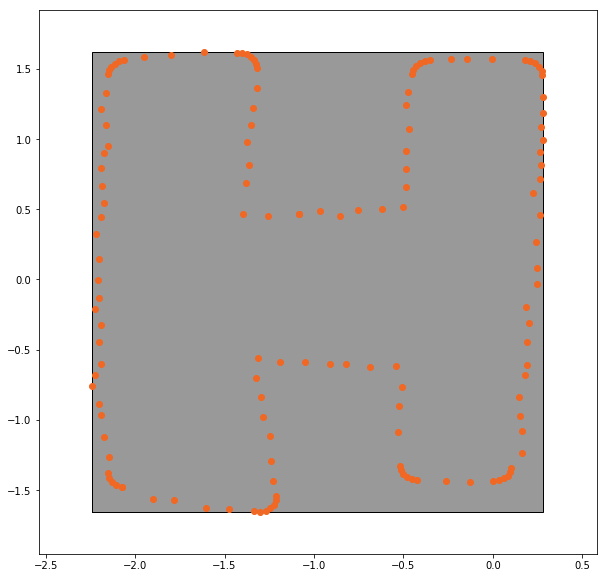

In [5]:
from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig

_ = plot_polygon(point_collection.envelope)
_ = pl.plot(x,y,'o', color='#f16824')


## shapely is powerful
Shapely enables tons of geometric set theoretic operations in python. It might be interesting to compute the convex hull, for instance.

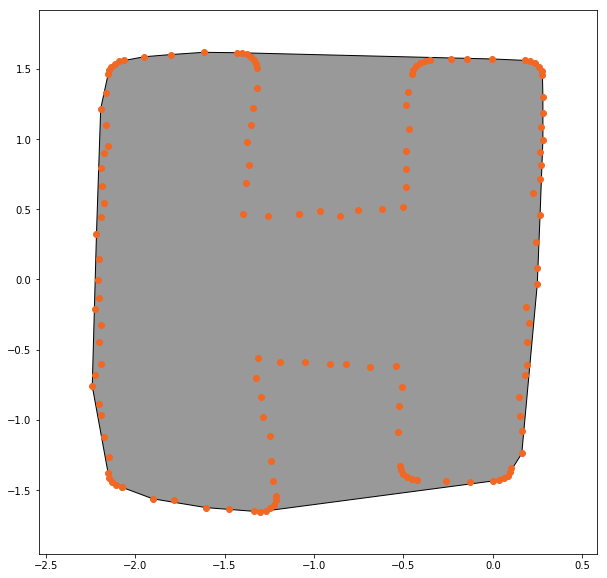

In [6]:
convex_hull_polygon = point_collection.convex_hull
_ = plot_polygon(convex_hull_polygon)
_ = pl.plot(x,y,'o', color='#f16824')

## not an H
Convex Hull does a neat thing for us. It draws a polygon around the original points, but without any margin (contrast with envelope.)

It doesn't look like an H though. What if we want to derive a polygon that's more representative of the density of these points?

## concave hull to the rescue
From Wikipedia:
> In computational geometry, an alpha shape, or α-shape, is a family of piecewise linear simple curves in the Euclidean plane associated with the shape of a finite set of points. They were first defined by Edelsbrunner, Kirkpatrick & Seidel (1983). The alpha-shape associated with a set of points is a generalization of the concept of the convex hull, i.e. every convex hull is an alpha-shape but not every alpha shape is a convex hull.

## basically, we can tighten up that convex hull
But shapely doesn't have an implementation of concave hull.

Sean Gillies has some [alpha shapes code](http://sgillies.net/blog/1155/the-fading-shape-of-alpha/ "Shapely guy Sean Gillies' blog"). The gist is, compute the Delaunay triangles for the points, and then only add the triangles that meet a certain heuristic.

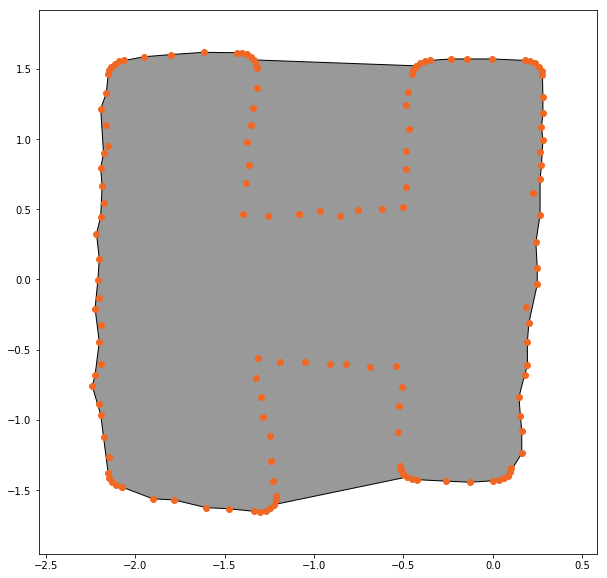

In [7]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

concave_hull, edge_points = alpha_shape(points, alpha=1.87)

_ = plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')

## well, that didn't really help.
It turns out that the alpha value and the scale of the points matters a lot when it comes to how well the Delaunay triangulation method will work. You can usually play with the alpha value to find a suitable response. I'll do both: scale up the "H" and try some different alpha values.

To get more points, I opened up QGIS, drew an "H" like polygon, generated regular points within the bounds of the "H", and then spatially joined them to remove any points outside the "H".

We have 497 points!


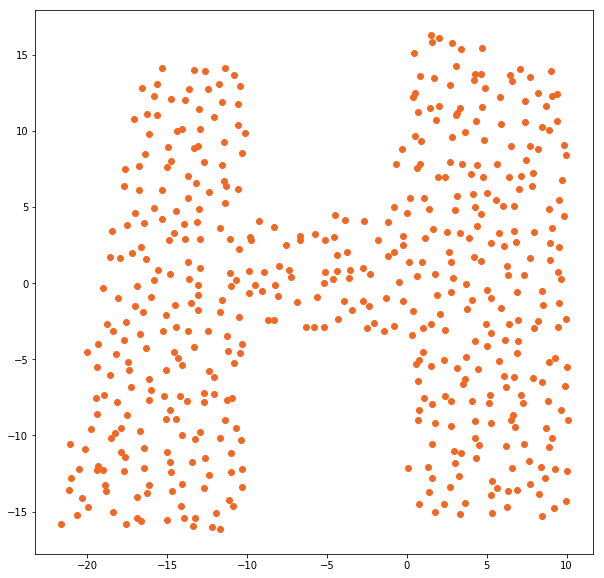

In [9]:
input_shapefile = 'data/demo_poly_scaled_points_join.shp'
new_shapefile = fiona.open(input_shapefile)
new_points = [geometry.shape(point['geometry']) for point in new_shapefile]
print("We have {0} points!".format(len(new_points)))
x = [p.coords.xy[0] for p in new_points]
y = [p.coords.xy[1] for p in new_points]
pl.figure(figsize=(10,10))
_ = pl.plot(x,y,'o', color='#f16824')

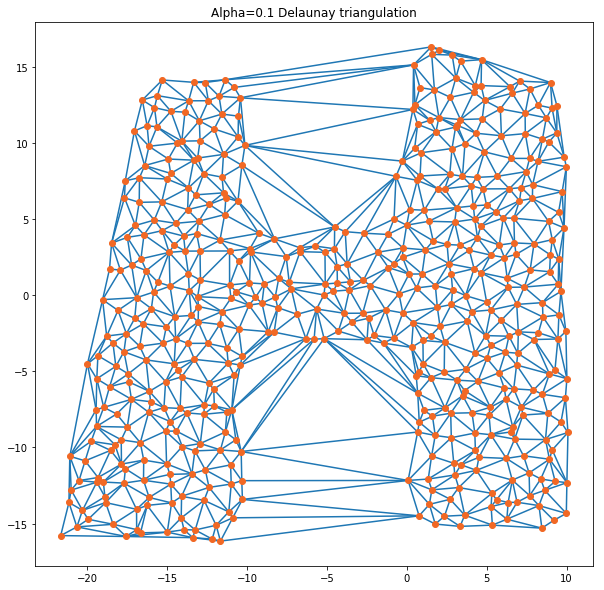

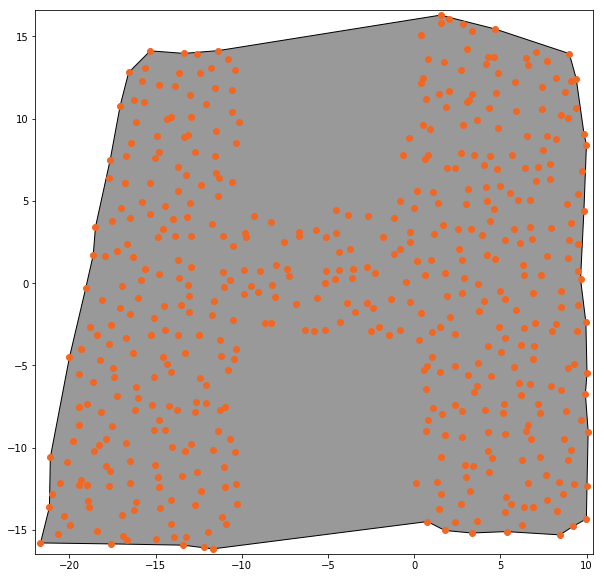

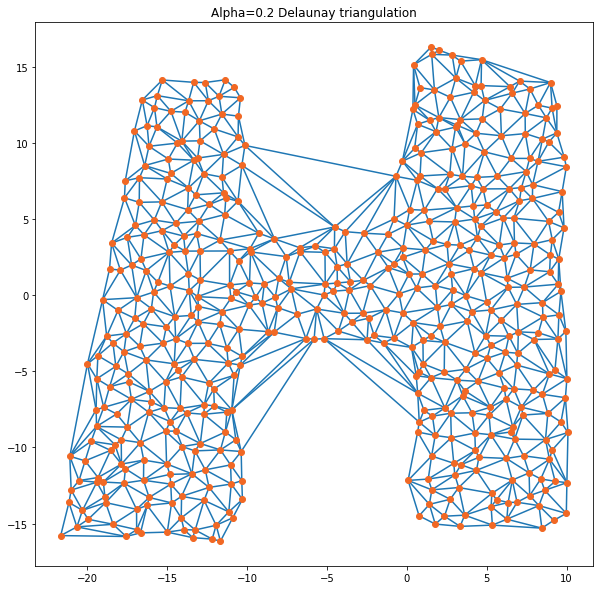

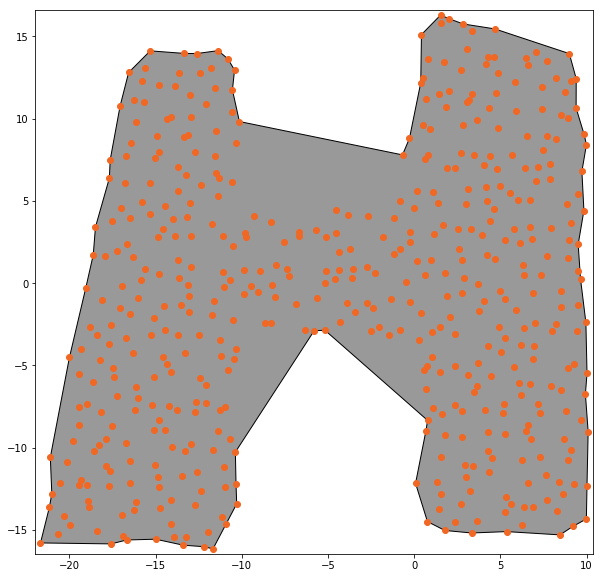

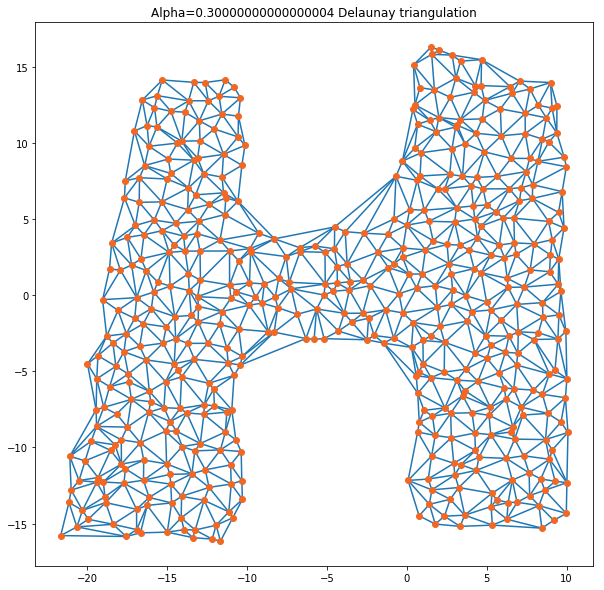

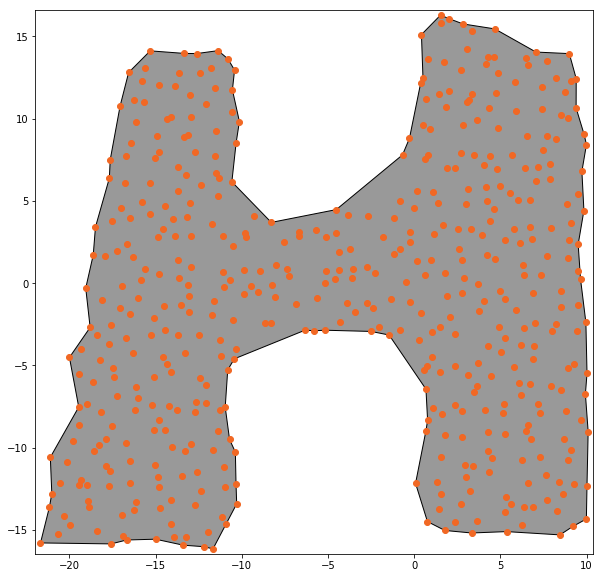

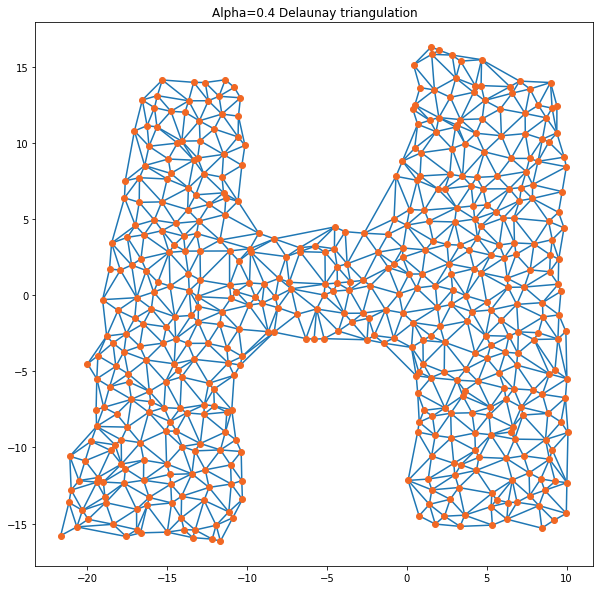

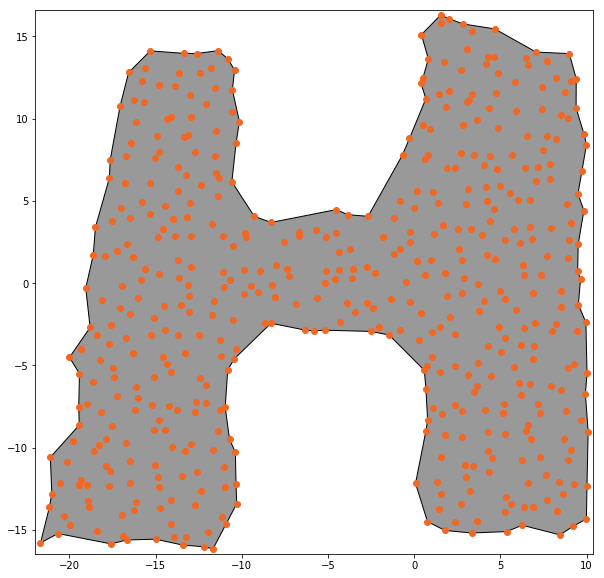

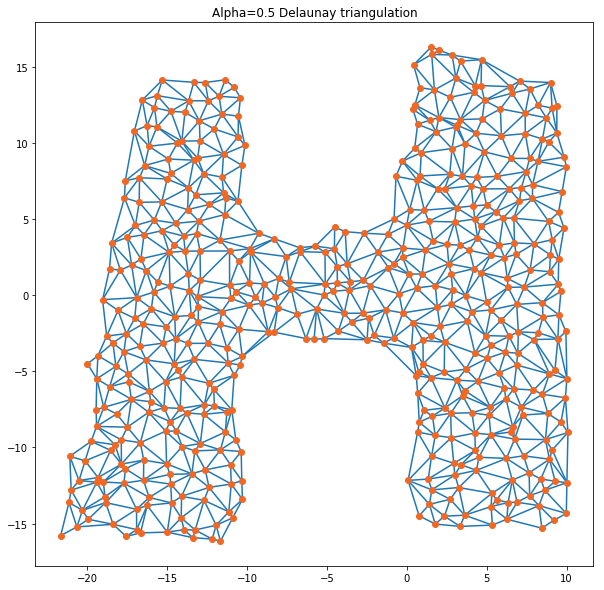

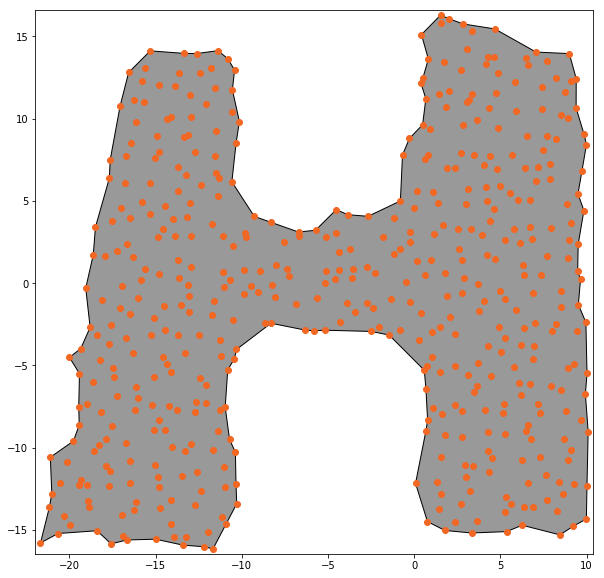

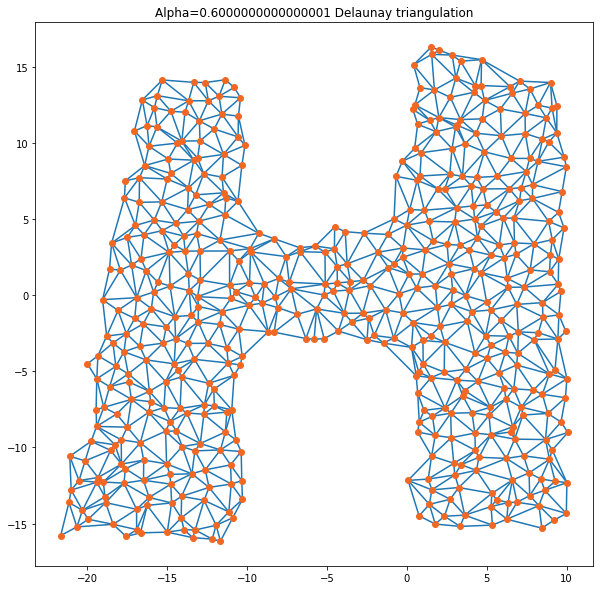

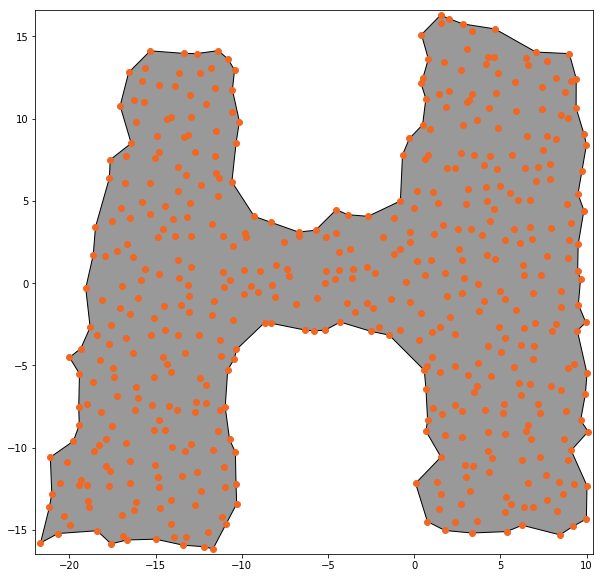

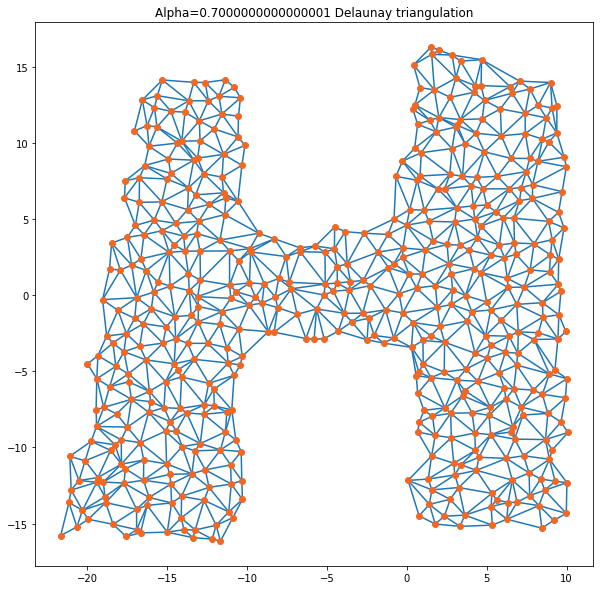

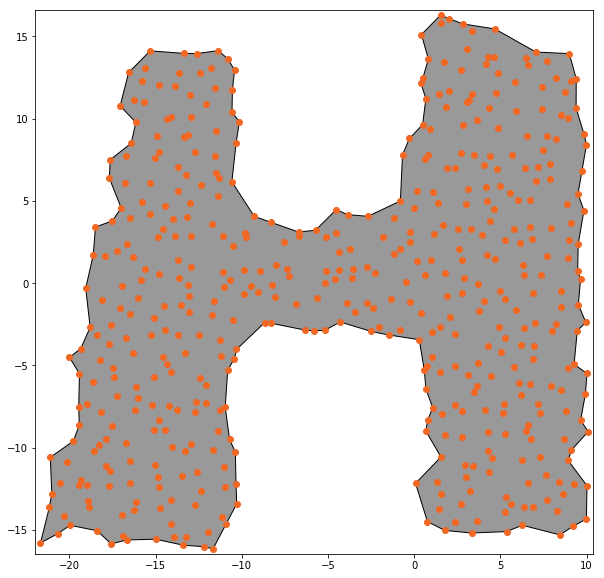

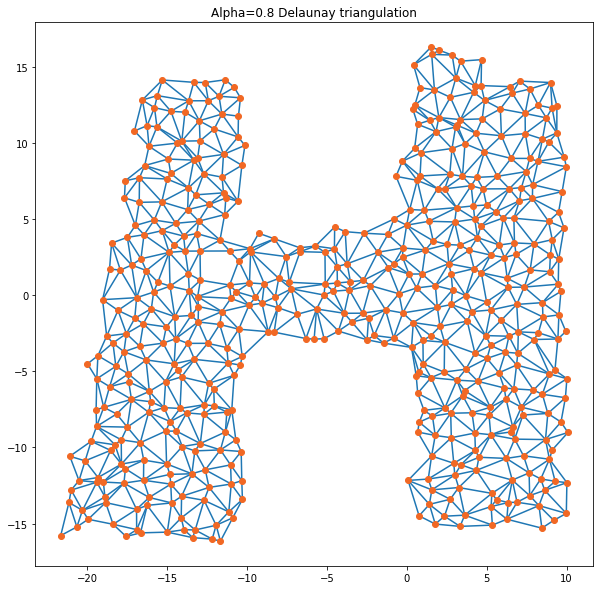

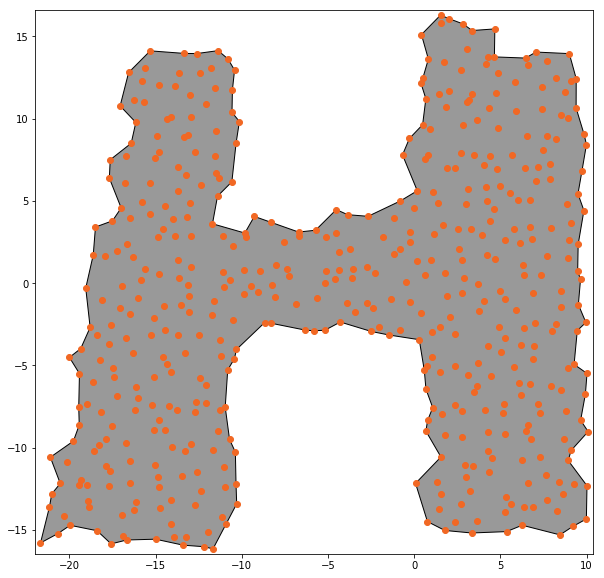

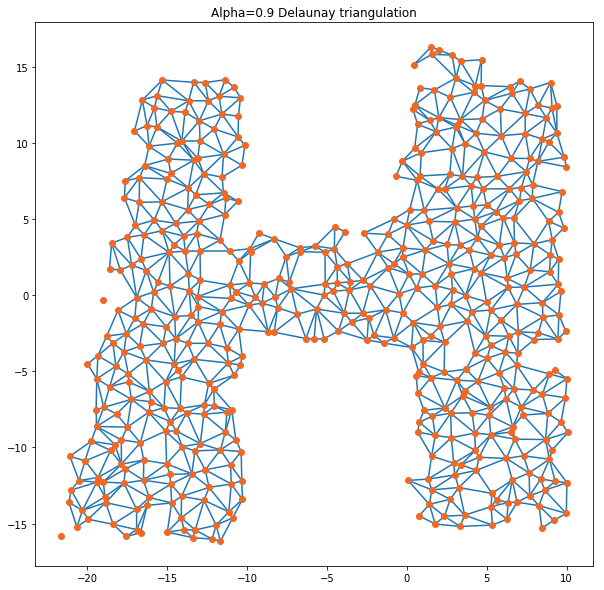

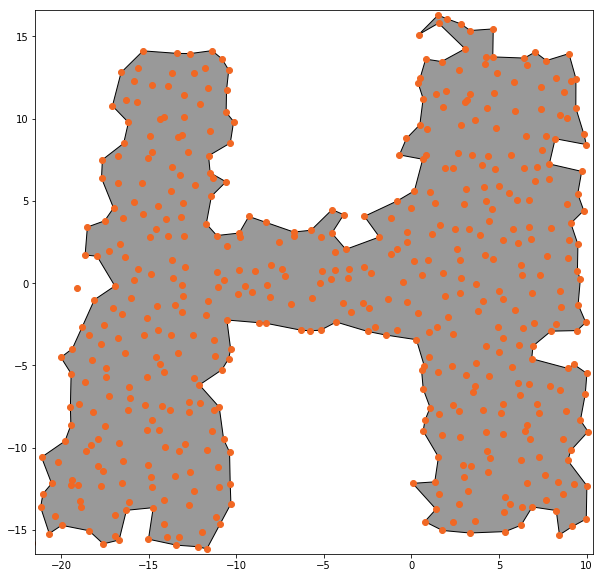

In [11]:
from matplotlib.collections import LineCollection

for i in range(9):
    alpha = (i+1)*.1
    concave_hull, edge_points = alpha_shape(new_points, alpha=alpha)

    #print concave_hull
    lines = LineCollection(edge_points)
    pl.figure(figsize=(10,10))
    pl.title('Alpha={0} Delaunay triangulation'.format(alpha))
    pl.gca().add_collection(lines)
    delaunay_points = np.array([point.coords[0] for point in new_points])
    pl.plot(delaunay_points[:,0], delaunay_points[:,1], 'o', color='#f16824')

    _ = plot_polygon(concave_hull)
    _ = pl.plot(x,y,'o', color='#f16824')

## alpha=0.4

So in this case, alpha of about 0.4 looks pretty good. We can use shapely's buffer operation to clean up that polygon a bit and smooth out any of the jagged edges.

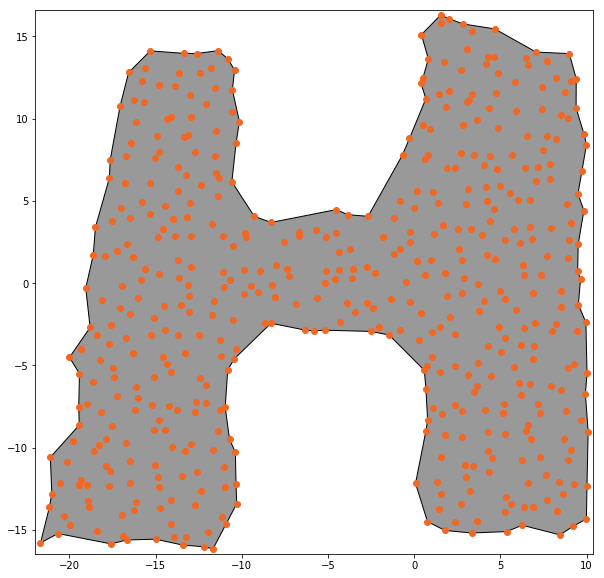

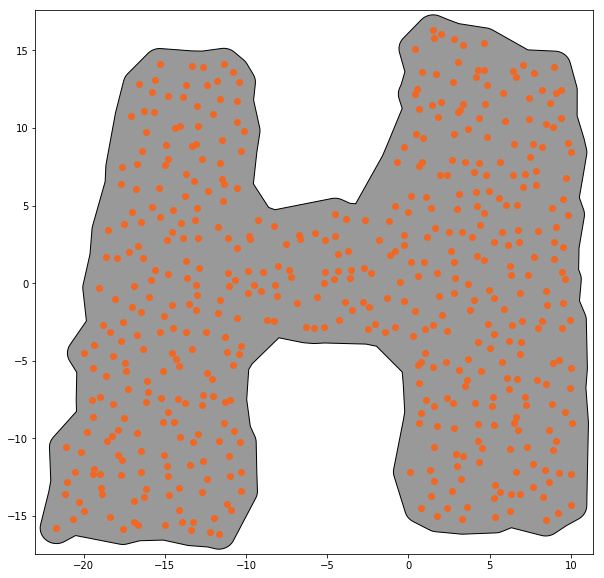

In [12]:
alpha = .4
concave_hull, edge_points = alpha_shape(new_points, alpha=alpha)

plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')
plot_polygon(concave_hull.buffer(1))
_ = pl.plot(x,y,'o', color='#f16824')